# Logistic fits for country COVID metrics.

* `zone_df` is pandas DataFrame containing information on each zone.
* `ts_df` is a pandas DataFrame containing time-series COVID metrics



In [1]:
## Initialisation
import pandas as pd
import geopandas
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from covid.grabbers import grab_wbdata, grab_JHU
from covid.utils import print_wb_indicators, print_wb_sources, get_x_day, rchop, drop_y
from covid.constants import POP_DF_RENAMED_COUNTRIES
from covid.statistics import LogisticModel

# set up the wbdata indicator (just build up the dict if you want more than one)
indicators = {'VA.EST': 'Voice and Accountability', 'GE.EST': 'Government Effectiveness'}

# We use two dataframes. One for for storing zone-wide wide and one for timeseries stuff
zone_df = pd.DataFrame(columns=['zone'])
ts_df = pd.DataFrame(columns=['zone', 'date'])


In [2]:
# Grab data - wbdata
# grab indicators and load into data frame
wb_df = grab_wbdata(indicators)

gov_df = wb_df.groupby(level='country').tail(5).groupby(level='country').mean()
gov_df.index.name = 'zone'

# Merge into zone_df
zone_df = pd.merge(zone_df, gov_df, on='zone', how='right')

del indicators
del gov_df
del wb_df
zone_df

,zone,Voice and Accountability,Government Effectiveness
0,Afghanistan,-1.718050,-1.838644
1,Albania,-0.251730,-0.629331
2,Algeria,-1.128412,-0.818300
3,American Samoa,NaN,NaN
4,Andorra,1.497404,1.431379
...,...,...,...
209,Virgin Islands (U.S.),NaN,NaN
210,West Bank and Gaza,-0.779990,-1.124713
211,"Yemen, Rep.",-0.862932,-0.736121
212,Zambia,-0.382936,-0.898444


In [3]:
## Timeseries
# Grab JHU time series data
ts_df = grab_JHU()


In [4]:
### Add population to zone_df
# Subnational population. Source=50
wb_df = grab_wbdata({'SP.POP.TOTL': 'population'})
pop_df = wb_df.xs('2018', level=1)
del wb_df

pop_df.index.name = 'zone'
pop_df.rename(index=POP_DF_RENAMED_COUNTRIES, inplace=True)


zone_df = pd.merge(zone_df, pop_df, on='zone', how='outer')



In [6]:
# Add population to ts_df
ts_df = pd.merge(ts_df.reset_index(), zone_df.set_index('zone')['population'], left_on='country', right_on='zone', how='left')
ts_df.set_index(['country', 'date'], inplace=True)
ts_df.sort_index(inplace=True)

# Calculate per population
for label in ('cases', 'deaths', 'recoveries'):
    ts_df[label + '_per_1M'] = (ts_df[label] * 10**6) / ts_df['population']


In [16]:
MIN_REGRESSION_DATAPOINTS = 5

label = 'deaths'
regression_predict_length = 10
regression_confidence = True
regression_confidence_levels = range(1, 3)
fit_method = 'leastsq'
log_scale = False
# countries = 'all'
# countries = ['United Kingdom', 'Italy', 'Spain', 'Denmark', 'Iran', 'Greece', 'US', 'Sweden', 'Austria', 'Germany', 'Norway', 'Japan', 'Australia', 'France', 'China']
countries = ['Denmark', 'US', 'Iran', 'United Kingdom']


if countries == 'all':
    countries = ts_df.reset_index()['country'].unique()


if label.startswith('cases'):
    n = 100
else:
    n = 10

# Calculate x day
x_days = ts_df.groupby('country').apply(lambda x: get_x_day(x, rchop(label, '_per_1M'), n))
ts_df = pd.merge(ts_df, x_days.rename('x_day'), on='country', suffixes=('', '_y'))
drop_y(ts_df)

ts_df['rel_day'] = ts_df['day'] - ts_df['x_day']

Processing country: Denmark
Processing country: US
Processing country: Iran
Processing country: United Kingdom


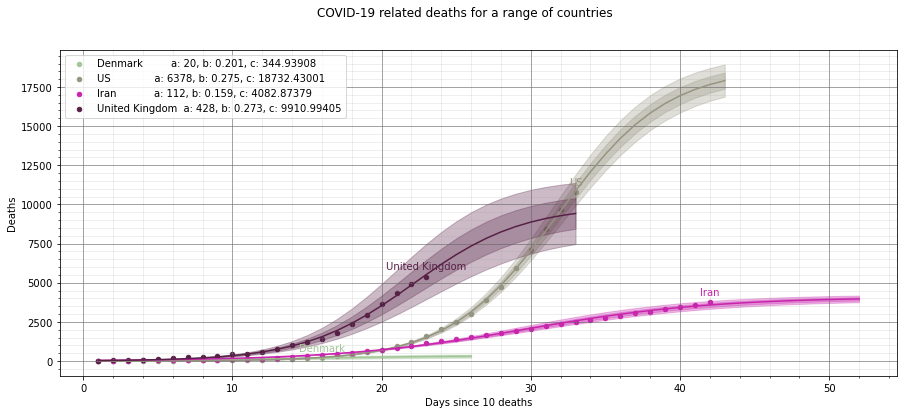

In [17]:

fig, ax = plt.subplots(figsize=(15, 6))
if log_scale:
    ax.set_yscale('log')


countries_fit = []
for country in countries:
    print(f'Processing country: {country}')
    col = np.random.rand(3,)

    country_df = ts_df.loc[country]

    #sub_df = ts_df[(ts_df['province_state'] == country) & (ts_df.index.is(country))]
    sub_df = ts_df.loc[country][ts_df.loc[country]['province_state'] == 'total']
    rel_df = sub_df.query('rel_day >= 1')

    if len(rel_df) < MIN_REGRESSION_DATAPOINTS:
        continue

    # rel_df.plot.scatter(x='rel_day', y=label)

    model = LogisticModel
    params = model.make_params(a=1000, b=0.3, c=1000)
    params['a'].min = 0
    params['b'].min = 0
    params['b'].max = 0.5
    params['c'].min = 0
    result = model.fit(rel_df[label], params, x=rel_df['rel_day'], method=fit_method)

    countries_fit.append({
        'zone': country,
        'fit_result': result,
        'fit_a': result.params['a'].value,
        'fit_b': result.params['b'].value,
        'fit_c': result.params['c'].value,
        'cases': rel_df.iloc[-1]['cases'],
        'deaths': rel_df.iloc[-1]['deaths'],
        'recoveries': rel_df.iloc[-1]['recoveries'],
        'cases_per_1M': rel_df.iloc[-1]['cases_per_1M'],
        'deaths_per_1M': rel_df.iloc[-1]['deaths_per_1M'],
        'recoveries_per_1M': rel_df.iloc[-1]['recoveries_per_1M'],
        'lat': rel_df.iloc[-1]['lat'],
        'long': rel_df.iloc[-1]['long'],
        'day': rel_df.iloc[-1]['day'],
        'rel_day': rel_df.iloc[-1]['rel_day'],
        'x': rel_df['rel_day'],
        'y': rel_df[label],
        'n': n,
        'col': col
    })

    # Labels with result parameters
    axlbl = f'{country:<15} a: {result.params["a"].value:.0f}, b: {result.params["b"].value:.3f}, c: {result.params["c"].value:.5f}'

    rel_df.plot.scatter(x='rel_day', y=label, color=[col], ax=ax, label=axlbl)
   
    # Regression 
    last_rel_day = rel_df['rel_day'].iloc[-1]
    regression_predict_days = np.arange(last_rel_day + 1, last_rel_day + regression_predict_length + 1)

    regression_range = np.append(rel_df['rel_day'].values, regression_predict_days)

    plt.plot(regression_range, result.eval(x=regression_range), color=col)

    # Regression confidence intervals
    if regression_confidence:
        for i in regression_confidence_levels:
            p = result.params
            plt.fill_between(regression_range, model.func(regression_range, p['a'] + i * p['a'].stderr, p['b'] + i * p['b'].stderr, p['c'] + i * p['c'].stderr), model.func(regression_range, p['a'] - i * p['a'].stderr, p['b'] - i * p['b'].stderr, p['c'] - i * p['c'].stderr), color=col, alpha=0.3)

    # Annotate last point
    x = rel_df.iloc[-1]['rel_day']
    y = rel_df.iloc[-1][label]
    ax.annotate(country, (x, y), color=col, textcoords='offset points', xytext=(0, 10), verticalalignment='center', horizontalalignment='center')

ax.set_ylabel(" ".join(label.split("_")).capitalize())
ax.set_xlabel(f"Days since {n} {label.strip('_per_1M')}")
fig.suptitle(f"COVID-19 related {label.strip('_per_1M')} for a range of countries")
plt.grid(b=True, which='major', color='#666666', linestyle='-', alpha=0.75)
plt.grid(b=True, axis='both', which='minor', color="#999999", linestyle='-', alpha=0.2)
plt.minorticks_on()
plt.legend()


In [134]:

world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))

world.rename(columns={'name': 'zone'}, inplace=True)

a = world.merge(new_df, on='zone', how='outer')

a.query('continent == "Europe"').query('zone != "Russia"').plot(column='deaths_per_1M', legend=True, cmap='summer', missing_kwds={
    "color": 'lightgrey'
})

NameError: name 'new_df' is not defined

# Country Bayersian fit


100%|██████████| 1000/1000 [01:36<00:00, 10.37it/s]
The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [58.06529849 27.23882496 57.98005807 80.46812704]


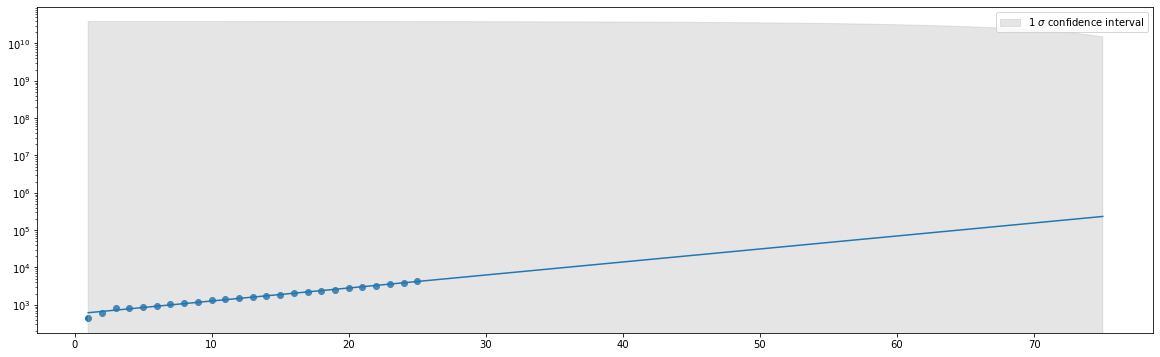

In [135]:
import lmfit
country = 'Denmark'
province_state = 'total'
label = 'cases'
regression_predict_length = 50
log_scale = True
emcee_factor = 1.0/1

c_df = ts_df.loc[country].query(f'province_state == "{province_state}"')

rel_df = c_df.query('rel_day >= 1')
# rel_df.plot(x='rel_day', y=label)

model = LogisticModel
params = model.make_params(a=1000, b=0.3, c=1000)
params['a'].min = 0
params['b'].min = 0
params['b'].max = 0.5
params['c'].min = 0
result_leastsq = model.fit(rel_df[label], params, x=rel_df['rel_day'], method='leastsq', nan_policy='omit')
result_nelder = model.fit(rel_df[label], params, x=rel_df['rel_day'], method='Nelder', nan_policy='omit')

emcee_kws = {
    'steps': int(round(1000 * emcee_factor)),
    'burn': int(round(300 * emcee_factor)),
#    'thin': 20,
    'is_weighted': False,
    'progress': True
}

emcee_params = result_nelder.params.copy()
emcee_params.add('__lnsigma', value=np.log(0.1), min=np.log(0.001), max=np.log(2.0))

result_emcee = model.fit(rel_df[label], emcee_params, x=rel_df['rel_day'], method='emcee', nan_policy='omit', fit_kws=emcee_kws)

last_rel_day = rel_df['rel_day'].iloc[-1]
regression_predict_days = np.arange(last_rel_day + 1, last_rel_day + regression_predict_length + 1)

regression_range = np.append(rel_df['rel_day'].values, regression_predict_days)

# result.plot()

fig, ax = plt.subplots(figsize=(20, 6))
if log_scale:
    ax.set_yscale('log')

p = result_leastsq.params

plt.scatter(rel_df['rel_day'], rel_df[label])
plt.plot(regression_range, model.func(regression_range, p['a'], p['b'], p['c']))
# Plot confidence intervals
for i in range(1, 2):
    dely = result_leastsq.eval_uncertainty(sigma=i, x=regression_range)
    plt.fill_between(regression_range, model.func(regression_range, p['a'], p['b'], p['c']) + dely, model.func(regression_range, p['a'], p['b'], p['c']) - dely, color='#ABABAB', alpha=0.3, label=f'{i} $\sigma$ confidence interval')

plt.legend()
#e_result = result.emcee()

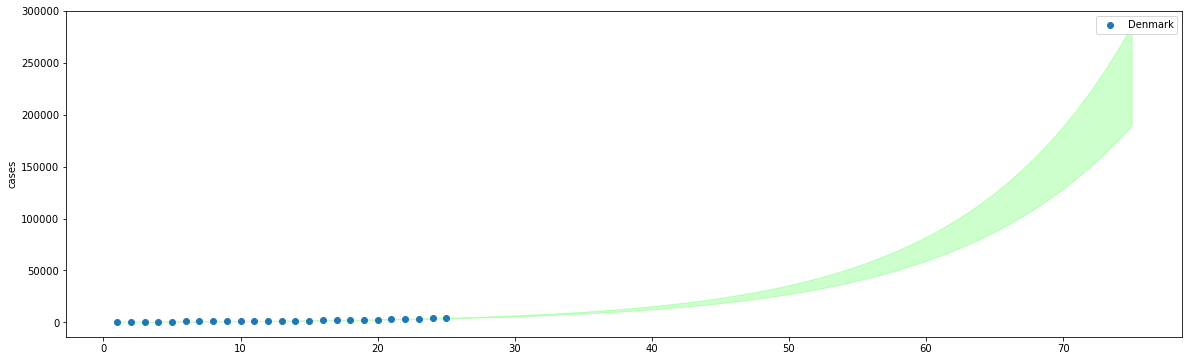

In [137]:
fig, ax = plt.subplots(figsize=(20, 6))
#ax.set_yscale('log')
ax.set_ylabel(label)
sigma_n = 1

# Emcee fit
p = result_emcee.params
color = (1.0, 0.0, 0.0)
#plt.fill_between(regression_range, model.func(regression_range, p['a'], p['b'] + p['b'].stderr, p['c']), model.func(regression_range, p['a'], p['b'] - p['b'].stderr, p['c']), color=color, alpha=0.2)
#plt.plot(regression_range, model.func(regression_range, p['a'], p['b'], p['c']), color=color, label='emcee fit')

# Least squares fit
p = result_leastsq.params
color = (0.0, 1.0, 0.0)
#plt.fill_between(regression_range, model.func(regression_range, p['a'] + p['a'].stderr, p['b'] + p['b'].stderr, p['c'] + p['c'].stderr), model.func(regression_range, p['a'] - p['a'].stderr, p['b'] - p['b'].stderr, p['c'] - p['c'].stderr), color=color, alpha=0.2)
#plt.plot(regression_range, model.func(regression_range, p['a'], p['b'], p['c']), color=color, label='leastsq fit')
plt.fill_between(regression_range, model.func(regression_range, p['a'] + sigma_n * p['a'].stderr, p['b'] + sigma_n * p['b'].stderr, p['c'] + sigma_n * p['c'].stderr), model.func(regression_range, p['a'] - sigma_n * p['a'].stderr, p['b'] - sigma_n * p['b'].stderr, p['c'] - sigma_n * p['c'].stderr), color=color, alpha=0.2)

# Nelder fit
p = result_nelder.params
color = (0.0, 0.0, 1.0)
#plt.fill_between(regression_range, model.func(regression_range, p['a'], p['b'] + p['b'].stderr, p['c']), model.func(regression_range, p['a'], p['b'] - p['b'].stderr, p['c']), alpha=0.2)
#plt.plot(regression_range, model.func(regression_range, p['a'], p['b'], p['c']), color=color, label='Nelder fit')

# Test
p = result_emcee.params
color = (0.0, 0.0, 0.0)
#plt.fill_between(regression_range, model.func(regression_range, p['a'] + sigma_n * p['a'].stderr, p['b'] + sigma_n * p['b'].stderr, p['c'] + sigma_n * p['c'].stderr), model.func(regression_range, p['a'] - sigma_n * p['a'].stderr, p['b'] - sigma_n * p['b'].stderr, p['c'] - sigma_n * p['c'].stderr), color=color, alpha=0.2)
#plt.plot(regression_range, model.func(regression_range, p['a'], p['b'], p['c']), color=color, label='test fit')


# Actual data
plt.scatter(rel_df['rel_day'], rel_df[label], label=f'{country}')
plt.legend()